## Home assigment von Alfons Dauer

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
from functools import reduce
from sklearn.preprocessing import StandardScaler

First we load the data into a pandas dataframe.

In [2]:
validation = pd.read_csv("validation.csv")
train = pd.read_csv("training.csv")

In [3]:
train.shape

(3700, 1)

Now let us take a first look into the data frame:

In [4]:
train.head(8)

,,,"v1;""v2"";""v3"";""v4"";""v5"";""v6"";""v7"";""v8"";""v9"";""v10"";""v11"";""v12"";""v13"";""v14"";""v15"";""v17"";""v18"";""v19"";""classLabel"""
a;17,92;5,"4e-05;""u"";""g"";""c"";""v"";1","75;""f"";""t"";1;""t"";""g"";80;5;8e+05;""t"";0;""no."""
b;16,92;3,"35e-05;""y"";""p"";""k"";""v"";0","29;""f"";""f"";0;""f"";""s"";200;0;2e+06;NA;0;""no."""
b;31,25;0,"0001125;""u"";""g"";""ff"";""ff"";0;""f"";""t"";1;""f"";""g"";96;19;960000;""t"";0;""no.""",NaN
a;48,17;0,"0001335;""u"";""g"";""i"";""o"";0","335;""f"";""f"";0;""f"";""g"";0;120;0;NA;0;""no."""
b;32,33;0,"00035;""u"";""g"";""k"";""v"";0","5;""f"";""f"";0;""t"";""g"";232;0;2320000;""f"";0;""no."""
a;34,83;0,"000125;""y"";""p"";""i"";""h"";0","5;""f"";""f"";0;""t"";""g"";160;0;1600000;""f"";0;""no."""
a;26,"17;2e-04;""u"";""g"";""j"";""j"";0;""f"";""f"";0;""t"";""g"";276;1;2760000;NA;0;""no.""",NaN,NaN
b;21,17;8,"75e-05;""y"";""p"";""c"";""h"";0","25;""f"";""f"";0;""f"";""g"";280;204;2800000;NA;0;""no."""


## 1a)
This doesen't look nice. First things that got my attention:

1. We have missing values: The rows seems to be filled from left to right, i.e. if there is any variable missing it will lead to a NaN in the only column on the very right.
2. The variables have to be seperated from one another.
3. There are multiple index and some information is written into them. Also I do not know if there is in fact a real index or not. The first one seems real so i will keep it as an index for now. (I tried it later as a variable and it did improve the model by 5% accuracy but since i don't know whether it is an index or not and i am afraid of data leakage and i did not keep it in my final model)
4. The variable names are non-descriptive. This leads to: 
    - feature engineering with a priori knowledge is impossible
    - we don't know if some variables are rounded and continuous or categorical/ordinal
    - we don't know if false positives and false negatives have the same cost
    - no way of interpreting the results

In [5]:
sum(train.isnull().any(axis=1))

1691

Thats a lot of rows with missing values considering we only have 3700 rows to begin with. Trying to recover the missing values could be worth the hassle but for this we need to find out what variables are acutally missing and i would need more time. So i just drop them for now.

In [6]:
train = train.dropna()


## 1b) 
So far i don't find it necessary to remove features since we don't have that many, even if some are probably useless like the one with a bunch of zeros in front. Also the variable 'v18' has a lot of NAs but since it is categorical i will just remove it after one-hot encoding the available information of that variable.

## 2.
Now let us explore the validation data.

In [7]:
validation.head(8)

,,,"v1;""v2"";""v3"";""v4"";""v5"";""v6"";""v7"";""v8"";""v9"";""v10"";""v11"";""v12"";""v13"";""v14"";""v15"";""v17"";""v18"";""v19"";""classLabel"""
b;32,33;0,"00075;""u"";""g"";""e"";""bb"";1","585;""t"";""f"";0;""t"";""s"";420;0;4200000;NA;1;""no."""
b;23,58;0,"000179;""u"";""g"";""c"";""v"";0","54;""f"";""f"";0;""t"";""g"";136;1;1360000;NA;0;""no."""
b;36,42;7,"5e-05;""y"";""p"";""d"";""v"";0","585;""f"";""f"";0;""f"";""g"";240;3;2400000;NA;1;""no."""
b;18,42;0,"0010415;""y"";""p"";""aa"";""v"";0","125;""t"";""f"";0;""f"";""g"";120;375;1200000;NA;0;""no."""
b;24,5;0,"0013335;""y"";""p"";""aa"";""v"";0","04;""f"";""f"";0;""t"";""g"";120;475;1200000;""f"";1;""no."""
a;39,"08;4e-04;""u"";""g"";""c"";""v"";3;""f"";""f"";0;""f"";""g"";480;0;4800000;""f"";0;""no.""",NaN,NaN
b;23,"42;1e-04;""u"";""g"";""c"";""v"";0","5;""f"";""f"";0;""t"";""s"";280;0;2800000;NA;1;""no.""",NaN
b;29,58;0,"000475;""u"";""g"";""m"";""v"";2;""f"";""t"";1;""t"";""g"";460;68;4600000;""t"";0;""no.""",NaN


The findings from 1) hold up for the most part. The leftmost index has duplicates already in the header which makes it unlikely that it is an index. Again we remove the rows with missing data.

In [8]:
sum(validation.isnull().any(axis=1))

75

In [9]:
validation = validation.dropna()

Next we clean the data.

In [10]:
"""
function to tidy up the data frame
"""
def tidy_data(df):
    
    flat_data = index_to_data(df)
    column_names = get_column_names(df)
    index_names = get_index_names(df)
    
    data = pd.DataFrame(flat_data, columns = column_names, index = index_names)
    data = data.replace('"', '', regex=True)
    
    return data

"""
function to combine the data from all the indeces with the row data
"""
def index_to_data(df):

    # put the data from the index into the columns
    temp = []
    for i in range(df.shape[0]):
        temp.append(list(df.index[i][1:]) + list(df.iloc[i]))
        
    # flatten data of every row into one list
    flat_data = []
    for i in range(df.shape[0]):
        flat_data.append([x.split(';') for x in temp[i] if str(x) != 'nan'])
        flat_data[i] = sum(flat_data[i], [])
        
    # check if all rows have the same length
    len_first = len(flat_data[0]) if flat_data else None
    assert all(len(i) == len_first for i in flat_data), "Not all datapoints have the same number of dimensions after removing na and flattening"
    
    return flat_data

"""
function to get the column names of our df
"""
def get_column_names(df):
    column_names = list(df)[0].replace('"', '').split(";")
    column_names.insert(15, 'v16')
    
    return column_names


"""
function to get the index names of our df
"""
def get_index_names(df):
    
    # for some reason the vectorized version does not work so i use a for loop
    index_names = []
    for i in range(df.shape[0]):
        index_names.append(train.index[i][0])

    return index_names


In [11]:
tidy_train = tidy_data(train)
tidy_val = tidy_data(validation)

tidy_train.head(10)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,classLabel
a;17,92,5,4e-05,u,g,c,v,1,75,f,t,1,t,g,80,5,8e+05,t,0,no.
b;16,92,3,35e-05,y,p,k,v,0,29,f,f,0,f,s,200,0,2e+06,NA,0,no.
a;48,17,0,0001335,u,g,i,o,0,335,f,f,0,f,g,0,120,0,NA,0,no.
b;32,33,0,00035,u,g,k,v,0,5,f,f,0,t,g,232,0,2320000,f,0,no.
a;34,83,0,000125,y,p,i,h,0,5,f,f,0,t,g,160,0,1600000,f,0,no.
b;21,17,8,75e-05,y,p,c,h,0,25,f,f,0,f,g,280,204,2800000,NA,0,no.
b;28,92,3,75e-05,u,g,c,v,0,29,f,f,0,f,g,220,140,2200000,NA,0,no.
b;18,17,0,001025,u,g,c,h,1,085,f,f,0,f,g,320,13,3200000,NA,0,no.
a;24,75,0,0013665,u,g,q,h,1,5,f,f,0,f,g,280,1,2800000,f,0,no.
a;18,17,0,001,y,p,q,h,0,165,f,f,0,f,g,340,0,3400000,f,0,no.


Before we can work with our classification models we transform the data to numpy arrays and one-hot encode the categorical variables.

In [12]:
"""
function to transform the df into a matrix we can work with.
"""
def df_to_matrix(df, categorical_variables): # categorical_variables is a list of column names that are categorical/strings

    dummy_var, variable_names_dummies = dummy_encode(df, categorical_variables)
    
    df = df.drop(categorical_variables, axis = 1)
    
    variable_names = list(df.columns.values) + variable_names_dummies
    variable_names.remove('classLabel_yes.')
    
    DV, IV = get_IV_DV(df, dummy_var)
    
    return DV, IV, variable_names

"""
function to dummy encode the categorical variables
"""
def dummy_encode(df, categorical_variables):
    
    dummy_var = pd.get_dummies(df[categorical_variables], drop_first = True)
    variable_names_dummies = list(dummy_var.columns.values)
    dummy_var = dummy_var.as_matrix()
    
    return dummy_var, variable_names_dummies

"""
function to split the data into the independent variables and dependent variable. The DV has to be the last dummy_var
"""
def get_IV_DV(numeric_var, dummy_var):
    
    DV = dummy_var[:, dummy_var.shape[1]-1]
    IV_dummies = dummy_var[:, :-1]
    
    # scale the numeric variables
    numeric_var = numeric_var.as_matrix()
    scaler = StandardScaler()
    IV_numeric = scaler.fit_transform(numeric_var.astype(float))
    
    IV = np.c_[IV_numeric, IV_dummies]
    
    return DV, IV

In [13]:
%%capture

#drop rows with NAs except if NA is in v18.
tidy_train = tidy_train[~tidy_train.drop('v18', axis = 1).eq('NA').any(1)]
tidy_val = tidy_val[~tidy_val.drop('v18', axis = 1).eq('NA').any(1)]

# concatenate train and val data for one-hot encoding
concatenation_point = tidy_train.shape[0]
tidy_data = pd.concat([tidy_train, tidy_val])

categorical_variables = ['v4', 'v5', 'v6', 'v7', 'v10', 'v11', 'v13', 'v14', 'v18', 'classLabel']

DV, IV, variable_names = df_to_matrix(tidy_data, categorical_variables)

# reverse the concatenation
DV_train = DV[:concatenation_point]
IV_train = IV[:concatenation_point,:]

DV_val = DV[concatenation_point:]
IV_val = IV[concatenation_point:,:]

Finally the data is ready for our models. First things first: Check how often every class appears in the data.

In [14]:
np.unique(DV, return_counts = True)

(array([0, 1], dtype=uint8), array([ 220, 1879], dtype=int64))

The classes are very unbalanced. There are a couple ways we can deal with this. I try simple oversampling first.

In [15]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
IV_resampled, DV_resampled = ros.fit_resample(IV_train, DV_train)

## 3. Build a model
(NAs were already removed)

It is generally a good idea to use a logistic regression as a first model to try in binary classification.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

lr = LogisticRegression(penalty = 'l2', random_state=0, solver = 'lbfgs')
scores = cross_validate(lr, IV_resampled, DV_resampled, cv = 5, return_train_score = True)

# accuracy on test folds from cross validation
scores

{'fit_time': array([0.04089093, 0.01296306, 0.00698161, 0.0069809 , 0.00797892]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([1., 1., 1., 1., 1.]),
 'train_score': array([1., 1., 1., 1., 1.])}

A perfect test score seems too good to be true but since i don't know anything about the data it is possible. Let us test the model on our validation set:

In [17]:
# accuracy of our model on validation data
lr_fit = lr.fit(IV_resampled, DV_resampled)

lr_fit.score(IV_val, DV_val)

0.4838709677419355

Thats unfortunate, there is probably some data leakage in our train data.

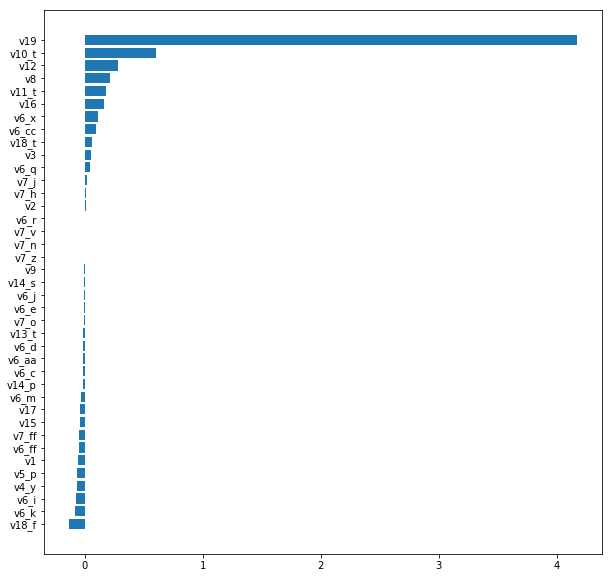

In [18]:
# plot the coefficients
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 10))

# sort variable_names and coefficients in ascending order
coef_sorted, var_sorted = zip(*sorted(zip(lr.coef_[0], variable_names)))

y_pos = np.arange(len(variable_names))

ax.barh(range(len(lr.coef_[0])), (coef_sorted))
ax.set_yticks(y_pos)
_ = ax.set_yticklabels(var_sorted)

Plotting the coefficients we see that the model is basically only looking at the variable 'v19'. The connection between v19 and classLabel only exists in the training data. So I drop the variable and retrain the model.

In [19]:
IV_resampled = np.delete(IV_resampled, variable_names.index('v19'), 1)
IV_val = np.delete(IV_val, variable_names.index('v19'), 1)

Retrain the same model.

In [20]:
lr = LogisticRegression(penalty = 'l2', random_state=0, solver = 'lbfgs')
scores = cross_validate(lr, IV_resampled, DV_resampled, cv = 5, return_train_score = True)

# accuracy on training data
scores

{'fit_time': array([0.05285716, 0.03291202, 0.053859  , 0.20046306, 0.20146132]),
 'score_time': array([0.        , 0.        , 0.01196504, 0.00099707, 0.00099778]),
 'test_score': array([0.86986301, 0.86712329, 0.87671233, 0.89041096, 0.87637363]),
 'train_score': array([0.87457162, 0.88793694, 0.87114462, 0.86943112, 0.88184932])}

 'test_score' and 'train_score' seem similar which is good. Now we test the model on our validation set.

In [21]:
# accuracy of our model on validation data
lr_fit = lr.fit(IV_resampled, DV_resampled)

lr_fit.score(IV_val, DV_val)

0.8467741935483871

Aha! it seems that removing that feature was all we needed to do to get a working model. We get an accuracy of 85% on our validation set.

Of course accuracy is not the best metric in our unbalanced data set. For a better assessement let us look at the confusion matrix:

In [22]:
from sklearn.metrics import confusion_matrix

pred_val = lr.predict(IV_val)
confusion_matrix(DV_val, pred_val)

array([[57, 12],
       [ 7, 48]], dtype=int64)

We get a precision of 0.8 and a recall of 0.87. The ratio between them seems decent.

With more time i could try other things to get better predictions.
In the end let us see the new coefficients.

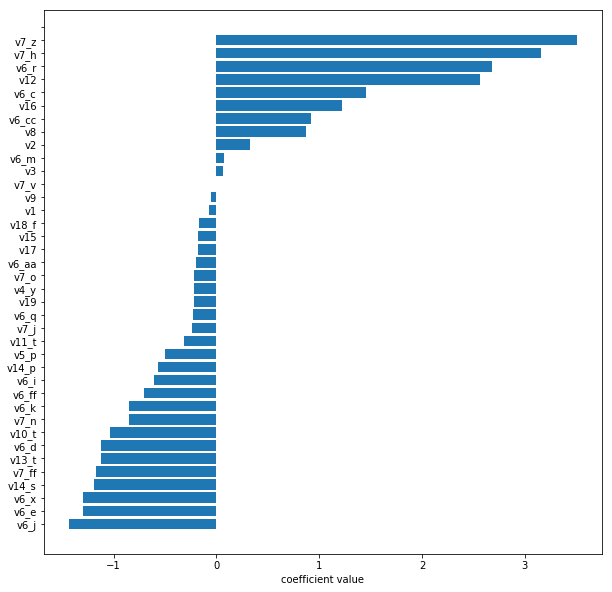

In [23]:
fig, ax = plt.subplots(figsize = (10, 10))

# sort variable_names and coefficients in ascending order
coef_sorted, var_sorted = zip(*sorted(zip(lr.coef_[0], variable_names)))

y_pos = np.arange(len(variable_names))

ax.barh(range(len(lr.coef_[0])), (coef_sorted))
ax.set_xlabel('coefficient value')
ax.set_yticks(y_pos)
_ = ax.set_yticklabels(var_sorted)

## Verbesserungsmöglichkeiten
(nach Priorität geordnet)
### Predictive Modeling:

- Irgendwie in Erfahrung bringen, was die Variablen eigentlich repräsentieren. Anschließend Feature Engineering.
- Modell anpassen, falls False Positives und False Negatives verschieden viele Kosten verursachen.
- mehr Modelle/mehr Hyperparametertuning wie z. B. tree based models, SVMs ausprobieren.
- Besser mit den NA Werten umgehen, anstatt die entsprechenden Zeilen einfach aus dem Modell zu schmeißen. Z.B. anhand der Sequenz herausfinden, welche Variablen in jeder Zeile fehlen und dann evtl. entsprechende Variablen rausschmeißen oder versuchen NaNs zu approximieren.
- Weitere Metriken neben Genauigkeit zur Evaluation des Algorithmus heranziehen, zum Beispiel ROC-AUC, F1-score. Das ist nicht so mega wichtig mMn, weil uns die Confusion Matrix doch recht solide Ergebnisse gezeigt hat.
- Anders mit den Unbalancierten Klassen umgehen. Z.B. SMOTE, ROC oder kostensensitive Lossfunktionen. Letzteres ist auch nützlich falls False Positives und False Negatives mit verschieden viel Kosten verbunden sind
- Ausreißer finden und passende Maßnahmen ergreifen. Niedrige Priorität weil es gar nicht so einfach ist, sie zu finden und Logistische Regression ist sowieso relativ robust gegen Ausreißer.

### Data Pipeline:
- Falls gute Ergebnisse sehr wichtig sind evtl. versuchen mehr Daten aufzutreiben.
- Pipeline verallgemeinern: Falls man erwarten kann, dass man immer mal wieder Datensets mit ähnlicher Struktur erhält den Datencleaning Prozess verallgemeinern.
- Unit Tests, Assert Lines
- Benutze Alternative zu as_matrix
